In [ ]:
from pynput.mouse import Button, Controller
import time

mouse = Controller()

while True:
    mouse.click(Button.left, 1)
    time.sleep(30)

# Home Credit Default Risk

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys

sys.path.append("../")
from helpers import *

In [2]:
# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe
pd.options.display.max_rows, pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option(
    "display.max_rows", None
)  # Print unlimited number of rows by setting to None, default is 10
pd.set_option(
    "display.max_columns", None
)  # Do not truncate columns to display all of them by setting to None
pd.set_option(
    "display.width", None
)  # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option(
    "display.max_colwidth", None
)  # Auto detect the max size of column and print contents of that column without truncation

(60, 20)

In [3]:
def reduce_mem_usage(df):
    """iterate through all the columns of a ../dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


print("-" * 80)
print("train")
train = pd.read_csv("../data/application_train.csv")

print("-" * 80)
print("test")
test = import_data("../data/application_test.csv")

print("-" * 80)
print("bureau_balance")
bureau_balance = import_data("../data/bureau_balance.csv")

print("-" * 80)
print("bureau")
bureau = import_data("../data/bureau.csv")

print("-" * 80)
print("credit_card_balance")
credit_card = import_data("../data/credit_card_balance.csv")

print("-" * 80)
print("installments_payments")
installments = import_data("../data/installments_payments.csv")

print("-" * 80)
print("pos_cash_balance")
pos_cash = import_data("../data/POS_CASH_balance.csv")

print("-" * 80)
print("previous_application")
previous_app = import_data("../data/previous_application.csv")

--------------------------------------------------------------------------------
train
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
--------------------------------------------------------------------------------
bureau_balance
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
--------------------------------------------------------------------------------
bureau
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
--------------------------------------------------------------------------------
credit_card_balance
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
--------------------------------------------------------------------------------
installments_payments
Memory usage of dataframe i

### Data model

There are 7 different sources of data:

- **train/application_test**: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

- **bureau**: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

- **bureau_balance**: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- **previous_application**: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

- **POS_CASH_BALANCE**: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- **credit_card_balance**: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- **installments_payment**: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


#### Schema visualization
<img src="../images/home_credit.png" alt="Alternative text" />

#### Column Description

In [4]:
desc = pd.read_csv("../data/HomeCredit_columns_description.csv", encoding="latin")
desc.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                  Identification if loan is cash or revolving   
3                                                                                                                                                                         Gender of the client   
4                                                                                                                                                                Flag if the client owns a car   

  Special  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

### Data glimpse

In [5]:
print("train -  rows:", train.shape[0], " columns:", train.shape[1])
print("application_test -  rows:", test.shape[0], " columns:", test.shape[1])
print("bureau -  rows:", bureau.shape[0], " columns:", bureau.shape[1])
print(
    "bureau_balance -  rows:",
    bureau_balance.shape[0],
    " columns:",
    bureau_balance.shape[1],
)
print(
    "credit_card_balance -  rows:",
    credit_card.shape[0],
    " columns:",
    credit_card.shape[1],
)
print(
    "installments_payments -  rows:",
    installments.shape[0],
    " columns:",
    installments.shape[1],
)
print(
    "previous_application -  rows:",
    previous_app.shape[0],
    " columns:",
    previous_app.shape[1],
)
print("POS_CASH_balance -  rows:", pos_cash.shape[0], " columns:", pos_cash.shape[1])

train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


In [6]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [7]:
train.shape, test.shape
train.shape[0] / (train.shape[0] + test.shape[0]) * 100  # Percentage of train data

((307511, 122), (48744, 121))

86.31766571697239

### Data imbalance

In [8]:
print(start + "1 = client with payment difficulties" + end)
print(start + "0 = all other cases" + end)
train.TARGET.value_counts(normalize=True)

1 = client with payment difficulties
0 = all other cases


0    0.919271
1    0.080729
Name: TARGET, dtype: float64

### Missing values

In [9]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


print(start + "Train Data" + end)
missing_values_table(train).head(10)
print(start + "Test Data" + end)
missing_values_table(test).head(10)
print(start + "Bureau Data" + end)
missing_values_table(bureau).head(10)
print(start + "Bureau Balance Data" + end)
missing_values_table(bureau_balance).head(10)
print(start + "Credit Card Data" + end)
missing_values_table(credit_card).head(10)
print(start + "Installments Data" + end)
missing_values_table(installments).head(10)
print(start + "POS Cash Data" + end)
missing_values_table(pos_cash).head(10)
print(start + "Previous Application Data" + end)
missing_values_table(previous_app).head(10)

Train Data


Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4

Test Data
Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MODE                    33495               68.7
COMMONAREA_MEDI                    33495               68.7
COMMONAREA_AVG                     33495               68.7
NONLIVINGAPARTMENTS_MEDI           33347               68.4
NONLIVINGAPARTMENTS_AVG            33347               68.4
NONLIVINGAPARTMENTS_MODE           33347               68.4
FONDKAPREMONT_MODE                 32797               67.3
LIVINGAPARTMENTS_MODE              32780               67.2
LIVINGAPARTMENTS_MEDI              32780               67.2
LIVINGAPARTMENTS_AVG               32780               67.2

Bureau Data
Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


Missing Values  % of Total Values
AMT_ANNUITY                    1226791               71.5
AMT_CREDIT_MAX_OVERDUE         1124488               65.5
DAYS_ENDDATE_FACT               633653               36.9
AMT_CREDIT_SUM_LIMIT            591780               34.5
AMT_CREDIT_SUM_DEBT             257669               15.0
DAYS_CREDIT_ENDDATE             105553                6.1
AMT_CREDIT_SUM                      13                0.0

Bureau Balance Data
Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Credit Card Data
Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


Missing Values  % of Total Values
AMT_PAYMENT_CURRENT                 767988               20.0
AMT_DRAWINGS_ATM_CURRENT            749816               19.5
AMT_DRAWINGS_OTHER_CURRENT          749816               19.5
AMT_DRAWINGS_POS_CURRENT            749816               19.5
CNT_DRAWINGS_ATM_CURRENT            749816               19.5
CNT_DRAWINGS_OTHER_CURRENT          749816               19.5
CNT_DRAWINGS_POS_CURRENT            749816               19.5
AMT_INST_MIN_REGULARITY             305236                7.9
CNT_INSTALMENT_MATURE_CUM           305236                7.9

Installments Data
Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
DAYS_ENTRY_PAYMENT            2905                0.0
AMT_PAYMENT                   2905                0.0

POS Cash Data
Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


Missing Values  % of Total Values
CNT_INSTALMENT_FUTURE           26087                0.3
CNT_INSTALMENT                  26071                0.3

Previous Application Data
Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


Missing Values  % of Total Values
RATE_INTEREST_PRIMARY             1664263               99.6
RATE_INTEREST_PRIVILEGED          1664263               99.6
AMT_DOWN_PAYMENT                   895844               53.6
RATE_DOWN_PAYMENT                  895844               53.6
NAME_TYPE_SUITE                    820405               49.1
DAYS_FIRST_DRAWING                 673065               40.3
DAYS_FIRST_DUE                     673065               40.3
DAYS_LAST_DUE_1ST_VERSION          673065               40.3
DAYS_LAST_DUE                      673065               40.3
DAYS_TERMINATION                   673065               40.3

In [10]:
def handle_missing_values(
    dataframe, high_threshold=50.0, placeholder_for_categorical="Unknown"
):
    for column in dataframe.columns:
        missing_percent = dataframe[column].isnull().mean() * 100

        # Drop columns with a high percentage of missing values
        if missing_percent > high_threshold:
            dataframe.drop(column, axis=1, inplace=True)

        # Impute missing values for numeric columns with the median
        elif dataframe[column].dtype in ["float64", "int64"]:
            dataframe[column].fillna(dataframe[column].median(), inplace=True)

        # Impute missing values for categorical columns with a placeholder or mode
        else:
            most_frequent = (
                dataframe[column].mode()[0]
                if dataframe[column].mode().empty == False
                else placeholder_for_categorical
            )
            dataframe[column].fillna(most_frequent, inplace=True)

    return dataframe


train = handle_missing_values(train, high_threshold=60)
bureau = handle_missing_values(bureau, high_threshold=50)
previous_app = handle_missing_values(previous_app, high_threshold=60)

### Variable types

In [11]:
train.dtypes.value_counts()

float64    49
int64      41
object     15
dtype: int64

### Data visualization

In [12]:
def plot_distribution(feature, color, desc):
    plt.figure(figsize=(10, 6))
    plt.title(f"Distribution of {feature} ({desc})")
    sns.distplot(train[feature].dropna(), color=color, kde=True, bins=100)
    plt.show()


def plot_distribution_comp(var, nrow=2):

    i = 0
    t1 = train.loc[train["TARGET"] != 0]
    t0 = train.loc[train["TARGET"] == 0]

    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12, 6 * nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw=0.5, label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5, label="TARGET = 0")
        plt.ylabel("Density plot", fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.legend()

    plt.show()

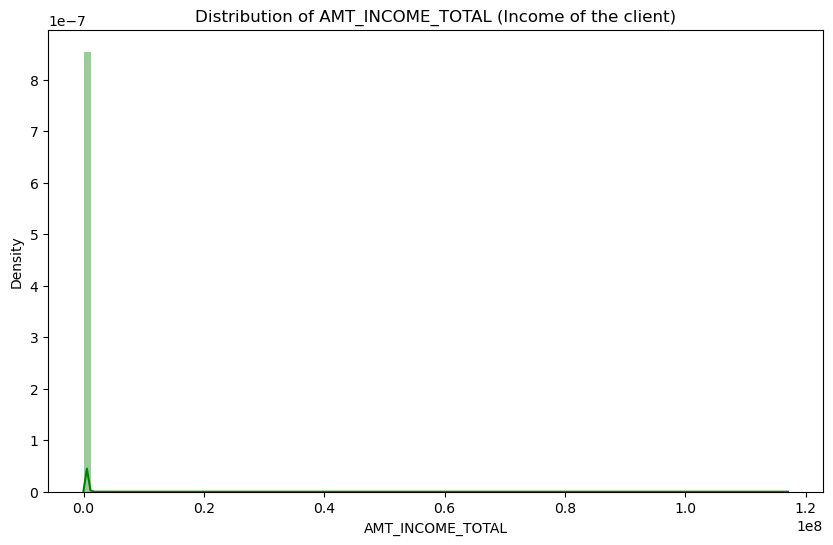

In [13]:
plot_distribution("AMT_INCOME_TOTAL", "green", "Income of the client")

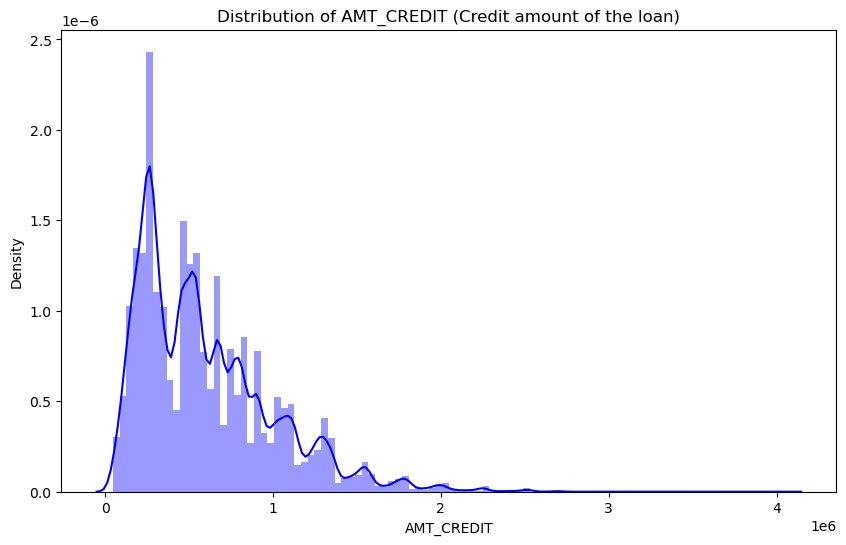

In [14]:
plot_distribution("AMT_CREDIT", "blue", "Credit amount of the loan")

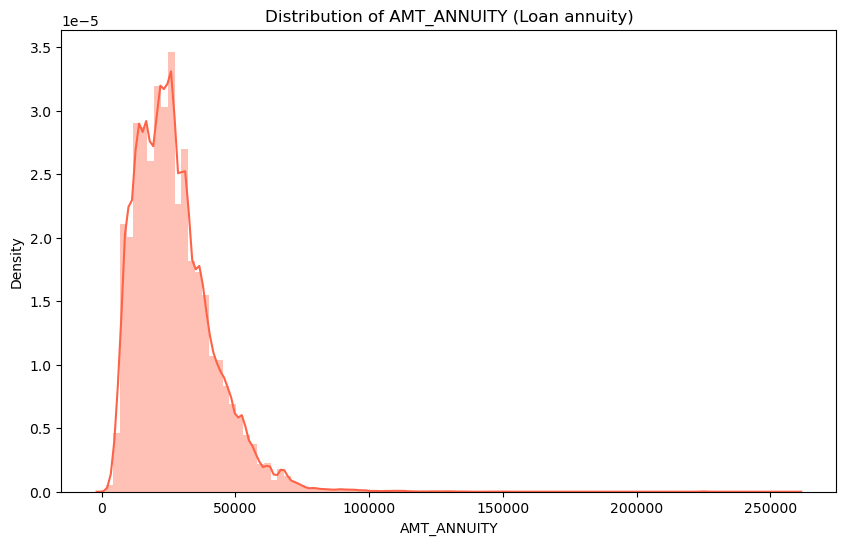

In [15]:
plot_distribution("AMT_ANNUITY", "tomato", "Loan annuity")

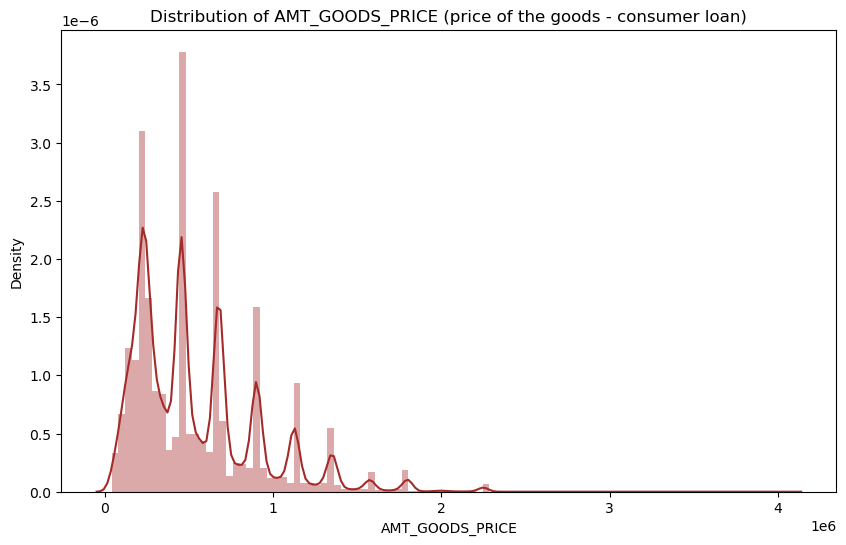

In [16]:
plot_distribution("AMT_GOODS_PRICE", "brown", "price of the goods - consumer loan")

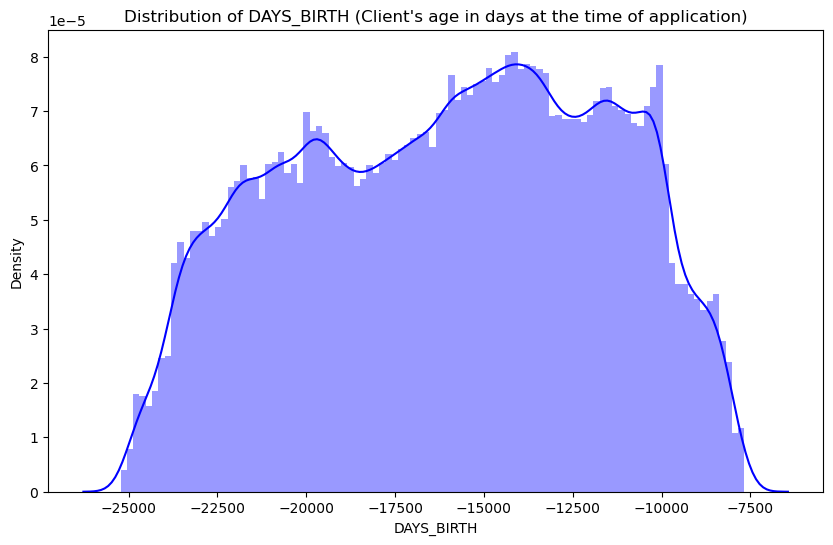

In [17]:
plot_distribution(
    "DAYS_BIRTH", "blue", "Client's age in days at the time of application"
)

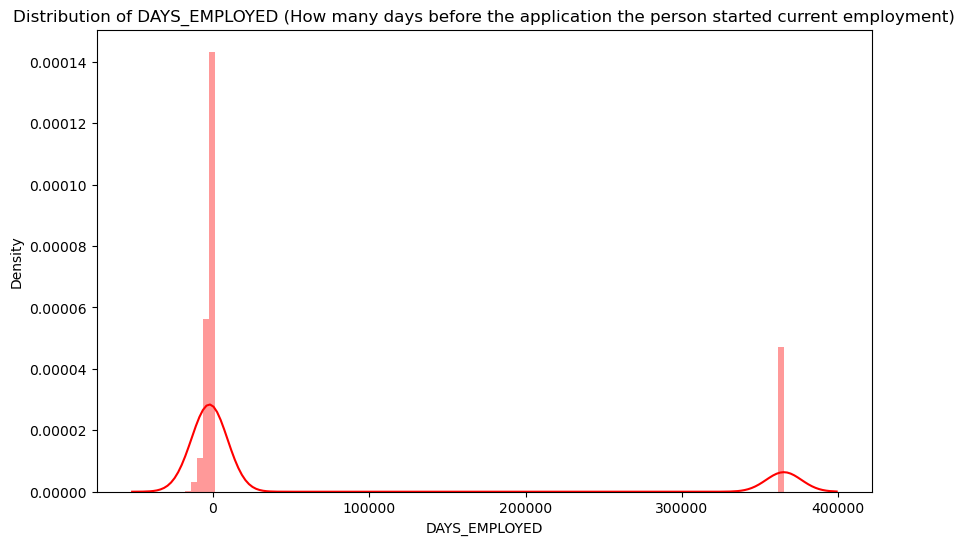

In [18]:
plot_distribution(
    "DAYS_EMPLOYED",
    "red",
    "How many days before the application the person started current employment",
)

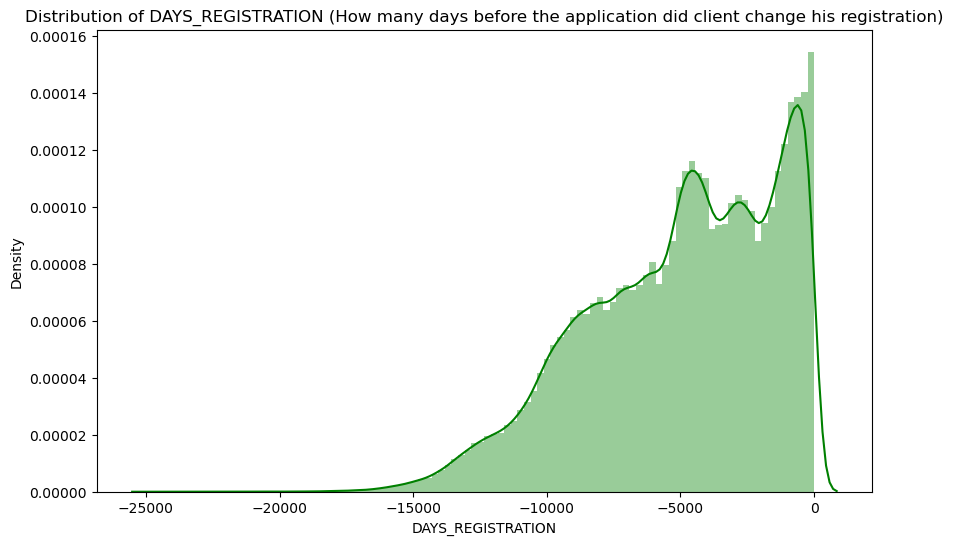

In [19]:
plot_distribution(
    "DAYS_REGISTRATION",
    "green",
    "How many days before the application did client change his registration",
)

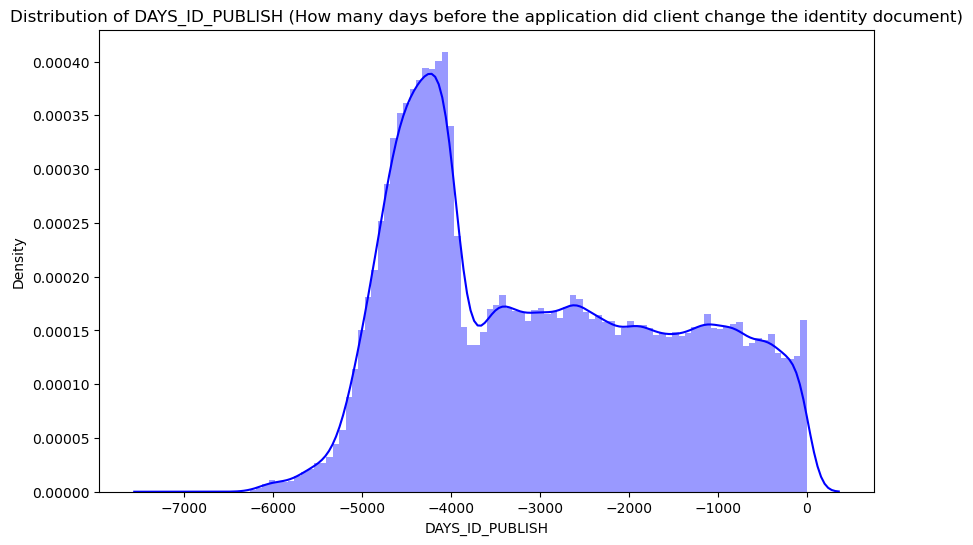

In [20]:
plot_distribution(
    "DAYS_ID_PUBLISH",
    "blue",
    "How many days before the application did client change the identity document",
)

### Comparison plots

<Figure size 640x480 with 0 Axes>

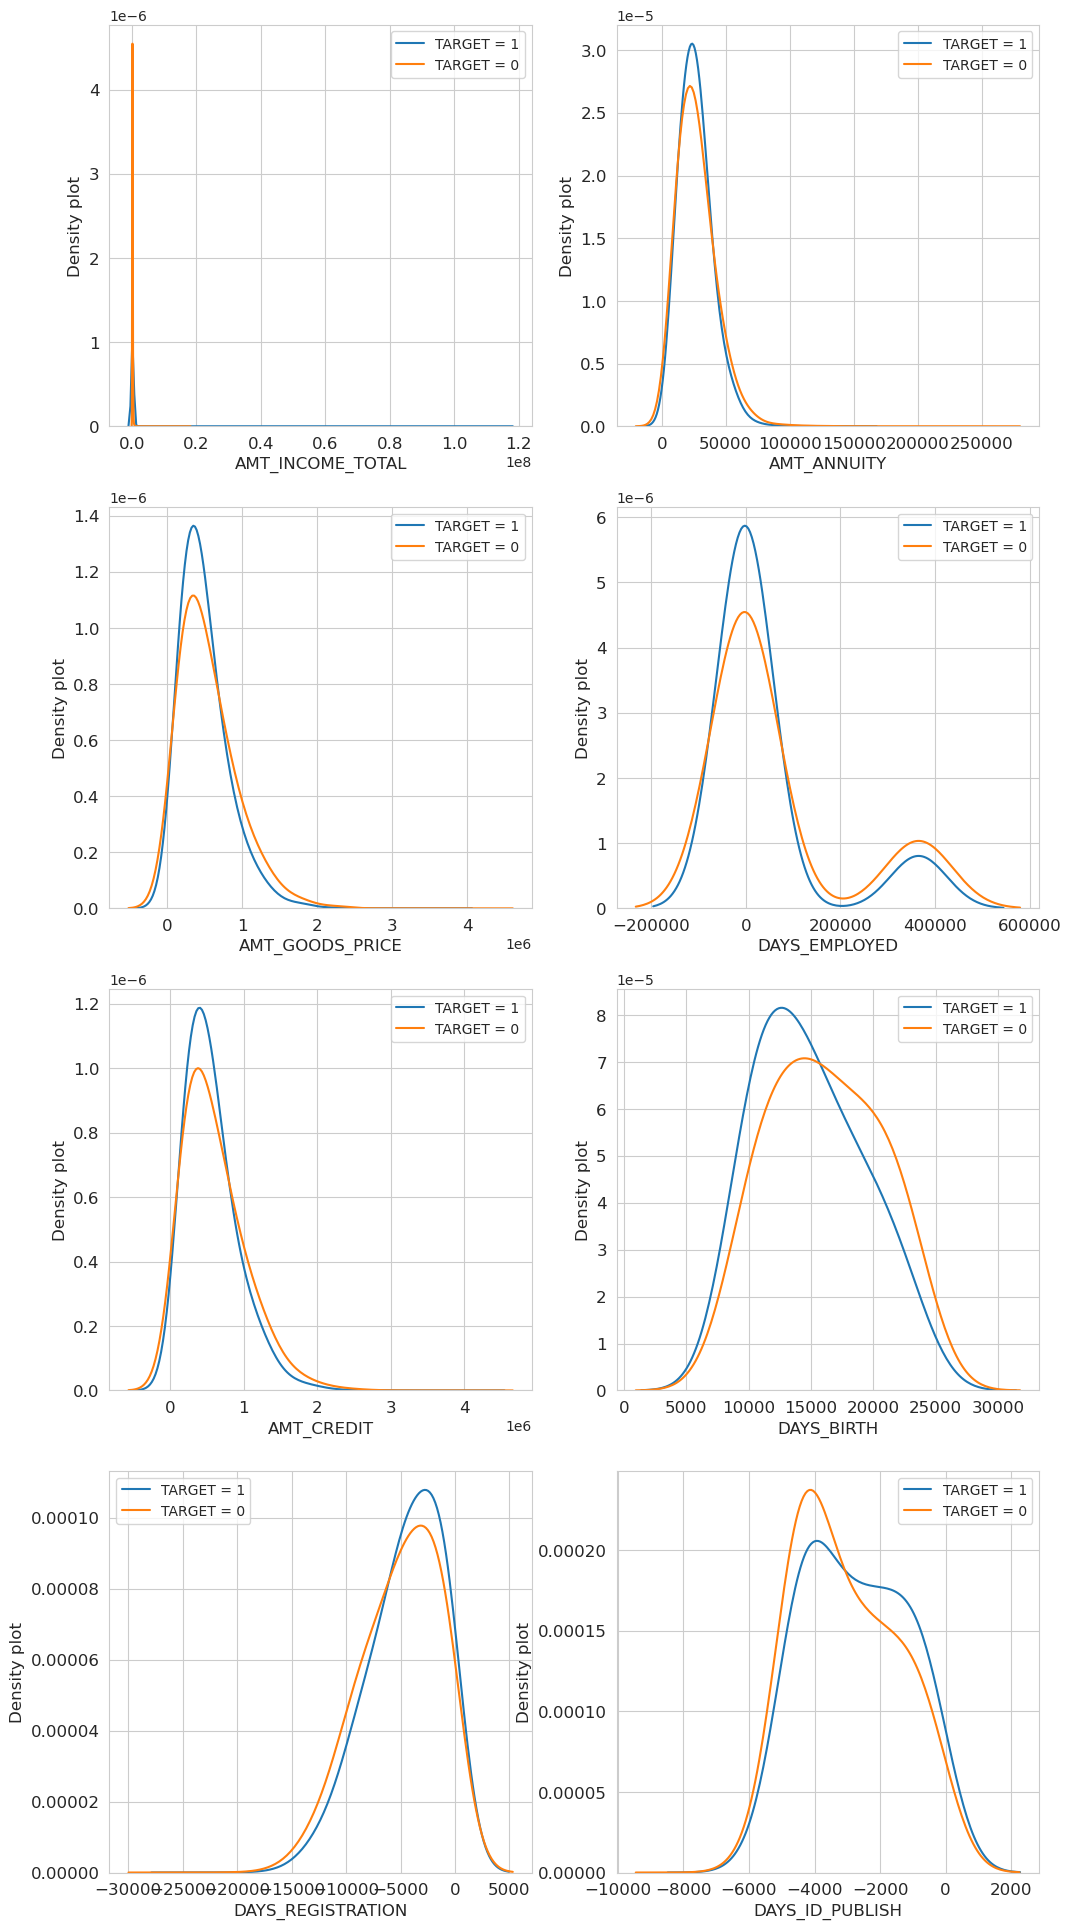

In [39]:
var = [
    "AMT_INCOME_TOTAL",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "DAYS_EMPLOYED",
    "AMT_CREDIT",
    "DAYS_BIRTH",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
]
plot_distribution_comp(var, nrow=4)

## Anomalies

In [23]:
(train["DAYS_BIRTH"] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [24]:
anom = train[train["DAYS_EMPLOYED"] == 365243]
non_anom = train[train["DAYS_EMPLOYED"] != 365243]
print(
    "Clienții fără anomalii au o rată de neplată a creditului de %0.2f%%"
    % (100 * non_anom["TARGET"].mean())
)
print(
    "Clienții cu anomalii au o rată de neplată a creditului de %0.2f%%"
    % (100 * anom["TARGET"].mean())
)
print("Există %d zile de angajare anomale" % len(anom))

Clienții fără anomalii au o rată de neplată a creditului de 8.66%
Clienții cu anomalii au o rată de neplată a creditului de 5.40%
Există 55374 zile de angajare anomale


## Correlations

In [25]:
correlations = train.corr()["TARGET"].sort_values()

# Display correlations
print("Most Positive Correlations:\n", correlations.tail(15))
print("\nMost Negative Correlations:\n", correlations.head(15))

Most Positive Correlations:
 FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031401
DEF_30_CNT_SOCIAL_CIRCLE       0.032394
LIVE_CITY_NOT_WORK_CITY        0.032518
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                 -0.160295
EXT_SOURCE_3                 -0.155892
EXT_SOURCE_1                 -0.098887
DAYS_EMPLOYED                -0.044932
AMT_GOODS_PRICE              -0.039623
FLOORSMAX_AVG                -0.039385
FLOORSMAX_MEDI               -0.039157
FLOORSMAX_MODE               -0.038377


## Age

In [26]:
train["DAYS_BIRTH"] = abs(train["DAYS_BIRTH"])
train["DAYS_BIRTH"].corr(train["TARGET"])

-0.07823930830982692

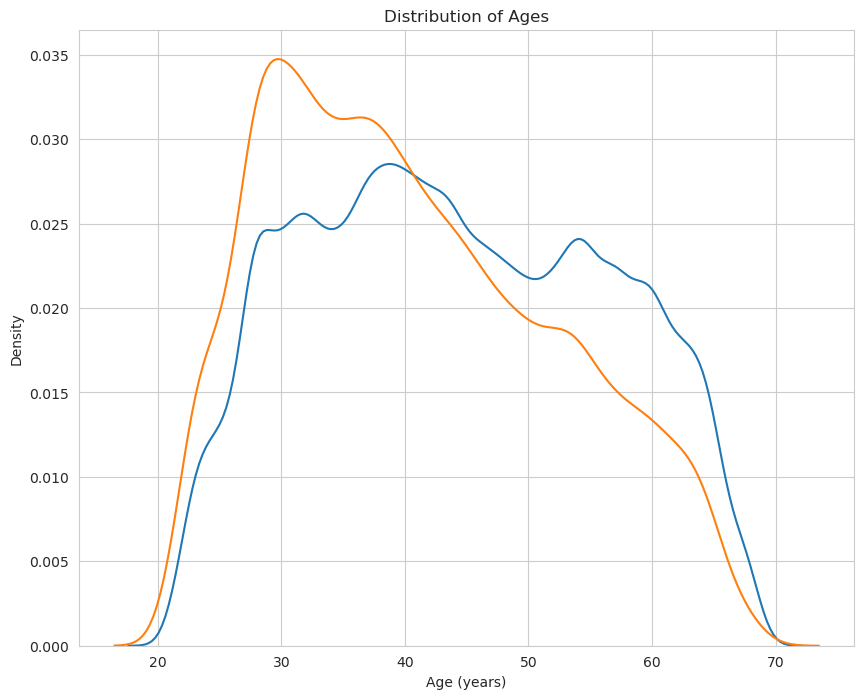

In [27]:
plt.figure(figsize=(10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train["TARGET"] == 0, "DAYS_BIRTH"] / 365, label="target == 0")

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train["TARGET"] == 1, "DAYS_BIRTH"] / 365, label="target == 1")

# Labeling of plot
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.title("Distribution of Ages");

In [28]:
age_data = train[["TARGET", "DAYS_BIRTH"]]
age_data["YEARS_BIRTH"] = age_data["DAYS_BIRTH"] / 365

# Bin the age data
age_data["YEARS_BINNED"] = pd.cut(
    age_data["YEARS_BIRTH"], bins=np.linspace(20, 70, num=11)
)
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [29]:
# Group by the bin and calculate averages
age_groups = age_data.groupby("YEARS_BINNED").mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

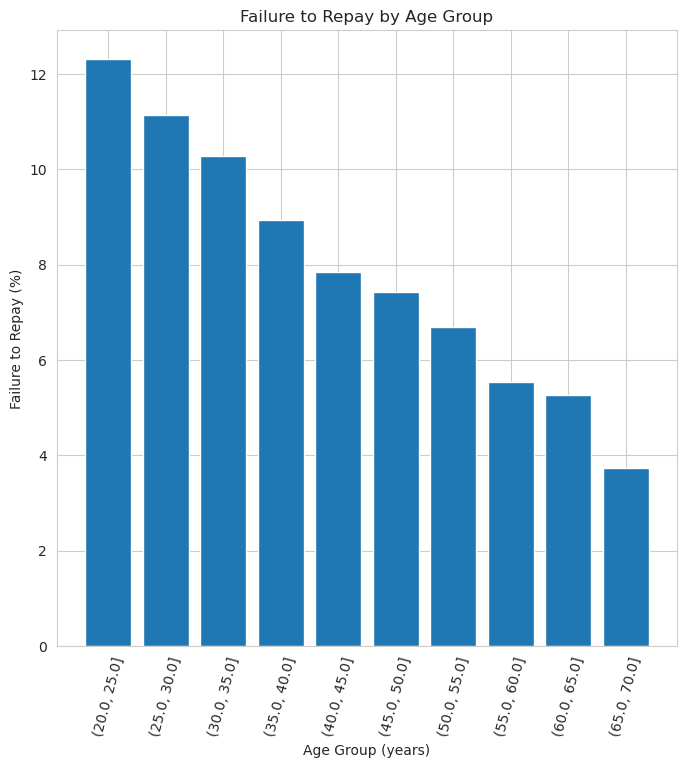

In [30]:
plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups["TARGET"])

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel("Age Group (years)")
plt.ylabel("Failure to Repay (%)")
plt.title("Failure to Repay by Age Group");

## Exterior Sources

In [31]:
ext_data = train[
    ["TARGET", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH"]
]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.098887     -0.160295     -0.155892   -0.078239
EXT_SOURCE_1 -0.098887      1.000000      0.134993      0.109100    0.362185
EXT_SOURCE_2 -0.160295      0.134993      1.000000      0.094147    0.091947
EXT_SOURCE_3 -0.155892      0.109100      0.094147      1.000000    0.178527
DAYS_BIRTH   -0.078239      0.362185      0.091947      0.178527    1.000000

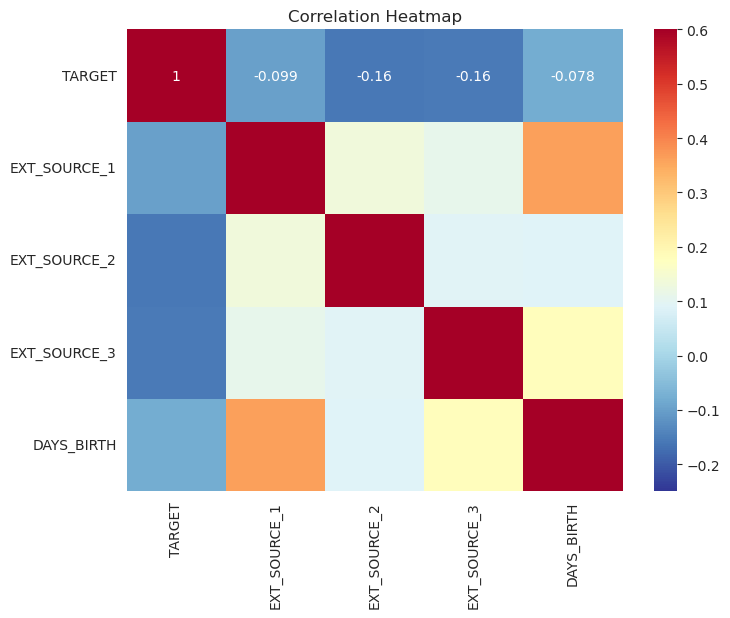

In [32]:
plt.figure(figsize=(8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title("Correlation Heatmap");

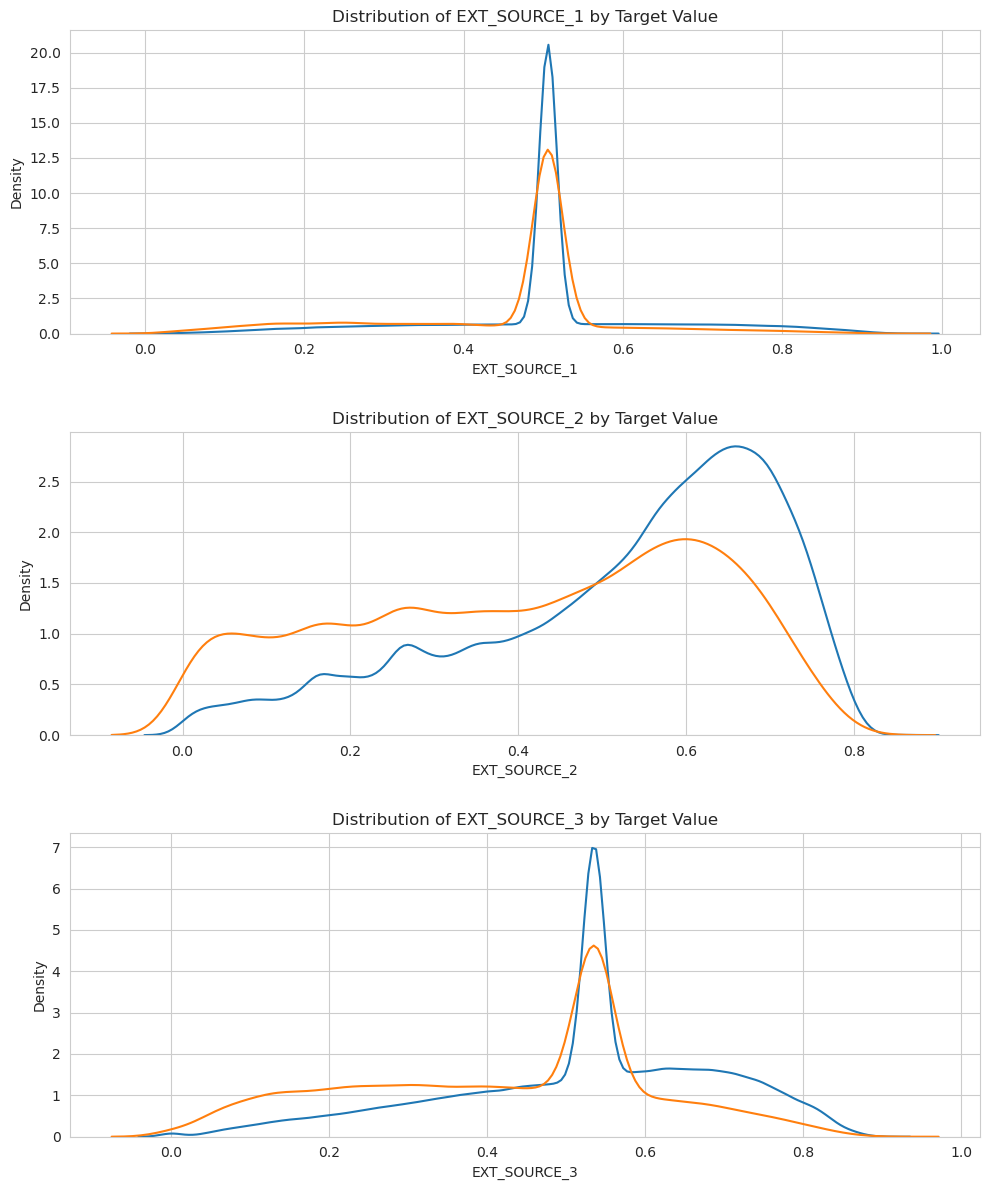

In [33]:
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train["TARGET"] == 0, source], label="target == 0")
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train["TARGET"] == 1, source], label="target == 1")

    # Label the plots
    plt.title("Distribution of %s by Target Value" % source)
    plt.xlabel("%s" % source)
    plt.ylabel("Density")

plt.tight_layout(h_pad=2.5);

In [34]:
train[train["TARGET"] == 0].EXT_SOURCE_1.describe()

count    282686.000000
mean          0.508396
std           0.138363
min           0.014568
25%           0.505998
50%           0.505998
75%           0.505998
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

In [35]:
# barplot train[train['TARGET'] == 0].EXT_SOURCE_1
plt.figure(figsize=(10, 8))

has_data_to_plot = train.loc[train["TARGET"] == 0, "EXT_SOURCE_3"].empty

# Return the check result and a sample of the data
has_data_to_plot, train.loc[train["TARGET"] == 0, "EXT_SOURCE_3"].head()

#

<Figure size 1000x800 with 0 Axes>

(False,
 1    0.535276
 2    0.729567
 3    0.535276
 4    0.535276
 5    0.621226
 Name: EXT_SOURCE_3, dtype: float64)

<Figure size 1000x800 with 0 Axes>

In [36]:
train.loc[train["TARGET"] == 0, "EXT_SOURCE_1"]

1         0.311267
2         0.505998
3         0.505998
4         0.505998
5         0.505998
6         0.774761
7         0.505998
8         0.587334
9         0.505998
10        0.319760
11        0.722044
12        0.464831
13        0.505998
14        0.721940
15        0.115634
16        0.505998
17        0.505998
18        0.505998
19        0.505998
20        0.565655
21        0.437709
22        0.505998
23        0.505998
24        0.505998
25        0.561948
27        0.505998
28        0.600396
29        0.297914
30        0.505998
31        0.274422
32        0.505998
33        0.505998
34        0.505998
35        0.505998
36        0.842763
37        0.804586
38        0.505998
39        0.505998
41        0.505998
43        0.505998
44        0.505998
45        0.505998
46        0.505998
47        0.505998
48        0.710427
49        0.505998
50        0.656225
51        0.311510
52        0.244562
53        0.189596
54        0.505998
55        0.552772
56        0.